In [1]:
"""
Naming convention:

Height: z
Electron Density: ne

Appendices:
Radar measurements: _r
"""


'\nNaming convention:\n\nHeight: z\nElectron Density: ne\n\nAppendices:\nRadar measurements: _r\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d
from scipy.interpolate import LSQUnivariateSpline
from scipy.integrate import quad
from scipy.optimize import minimize
import warnings
from time import sleep
%matplotlib widget

printing = 0

file = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/msis.txt'

kb = 1.380649e-23 #in SI units 
re = 6371000      #in m
g = 9.81          #in m/s^2


"""
Energy dissipation function
Preparation:
Copy values provided by Semeter and Kamalabadi
Fit it with LSQUnivariateSpline to get rid of wiggles
Evaluate calling the resulting function
Normalize such that int(energy_diss_f, -1, 1) = 1
"""
#raw data:
E_diss_table = np.array([
               [-0.525, 0.000], [-0.500, 0.006], [-0.475, 0.020], [-0.450, 0.027], [-0.425, 0.042], [-0.400, 0.058], [-0.375, 0.069], 
               [-0.350, 0.091], [-0.325, 0.123], [-0.300, 0.145], [-0.275, 0.181], [-0.250, 0.214], [-0.225, 0.248], [-0.200, 0.313],
               [-0.175, 0.360], [-0.150, 0.431], [-0.125, 0.499], [-0.100, 0.604], [-0.075, 0.728], [-0.050, 0.934], [-0.025, 1.237], 
               [ 0.000, 1.686], [ 0.025, 1.995], [ 0.050, 2.063], [ 0.075, 2.024], [ 0.100, 1.946], [ 0.125, 1.846], [ 0.150, 1.761], 
               [ 0.175, 1.681], [ 0.200, 1.596], [ 0.225, 1.502], [ 0.250, 1.421], [ 0.275, 1.346], [ 0.300, 1.260], [ 0.325, 1.190], 
               [ 0.350, 1.101], [ 0.375, 1.043], [ 0.400, 0.972], [ 0.425, 0.888], [ 0.450, 0.834], [ 0.475, 0.759], [ 0.500, 0.689], 
               [ 0.525, 0.636], [ 0.550, 0.567], [ 0.575, 0.504], [ 0.600, 0.450], [ 0.625, 0.388], [ 0.650, 0.334], [ 0.675, 0.282], 
               [ 0.700, 0.231], [ 0.725, 0.187], [ 0.750, 0.149], [ 0.775, 0.113], [ 0.800, 0.081], [ 0.825, 0.058], [ 0.850, 0.037], 
               [ 0.875, 0.023], [ 0.900, 0.010], [ 0.925, 0.002], [ 0.950, 0.000] 
    , [ 0.955, 0.000], [ 0.960, 0.000], [ 0.965, 0.000], [ 0.970, 0.000], [ 0.975, 0.000]
    , [ 0.980, 0.000], [ 0.985, 0.000], [ 0.990, 0.000], [ 0.995, 0.000], [ 1    , 0.000] 
                ])

#lsq fit using splines of order 5, using 5 datapoints to fit
i1 = 21
knots = np.arange(0.01, 1, 0.1)
knots = np.append(knots, [0.996])
spl = LSQUnivariateSpline(E_diss_table[i1:, 0], E_diss_table[i1:, 1], knots, k = 5)
cs = CubicSpline(E_diss_table[:, 0], E_diss_table[:, 1], bc_type = 'clamped')

if printing: 
    plt.figure()
    s = np.arange(-0.01, 1, 0.001)
    plt.title('Interpolation using LSQUnivariateSpline\n(might contain negative values)')
    plt.plot(s, spl(s))
    plt.plot(E_diss_table[i1:, 0], E_diss_table[i1:, 1], 'x')
    plt.grid()
    plt.xlabel('s/R')
    plt.ylabel('Lambda')

def E_diss_func(s, R):
    """
    Returns the energy dissipation function evaluated at s/R, (as defined in Semeter and Kamalabadi)
    by looking up the value in the E_diss_table and interpolating.
    R is the range of an electron in air with energy E.
    
    Parameters:
    s: scattering depth along the magnetic field: s = sec(I) * int(density dy)(0..inf), I: inclination angle of B
        scalar
    E: Energy of electron (eV)
        scalar
    
    Returns:
    e_diss: The energy dissipation function evaluated at s/R.
        scalar
    """
    if s/R < 0: 
        warnings.warn("s/R < 0 encountered in Energy dissipation function.")
        if s/R < -0.525:
            e_diss = 0
        else:
            index = int(np.floor(s/R/0.025 + 21))
            #print(s/R, E_diss_table[index, 0])
            #interpolation
            e_diss = cs(s/R)
    elif s/R >= 0.9486: 
        e_diss = 0
    else:
        e_diss = spl(s/R)
    if e_diss < 0: raise Exception('The dissipation function returns a negative value:', e_diss)
    return e_diss
    

def e_range(E):
    """
    Calculates the (density normalized) range of an electron in air in kg/m^2
    Actual distance d = R / density
    
    Parameters:
    E: Electron energy (eV)
        scalar or ndarray
    
    Returns:
    R: The density normalized range [kg m^-2]
        same shape as E
    """
    kE = E/1000
    R = (4.3 + 53.6 * (kE**(1.67)) - 0.038 * (kE**(-0.7)))*1e-6 #kg m-2
    return R


def scattering_depth_sh(rho, H, z, z_lower, inc_B):
    """
    Returns the scatterig depth at distance z, projected along the magnetic field
    Using the scale height sh(m(z), g(z), T(z)) to compute density variations, also to +inf
    
    Parameters:
    rho: mass density profile (discretized by z)
        ndarray [1 x n]
    H: scale height profile (discretized by z)
        ndarray [1 x n]
    z: heights of the profile (discretization parameter of rho and H)
        ndarray [1 x n]
    z_lower: lower integration boundary 
        scalar
    I: Inclination angle
        scalar
       
    Returns:
    scattering depth s in [kg m^-2]
    """
    #filtering in height:
    
    ind = z>=z_lower
    alt = z[ind]
    m_density = rho[ind]
    h_scale = H[ind]
        
    delta_alt = alt[1:] - alt[:-1]
    #s = 1/np.cos(inc_B) * np.sum(m_density[:-1] * delta_alt)
    #implicitly, above code asks for a high resolution in height.
    #if not enough measurements of rho in height, possible to interpolate using scale height
    #formula using scale heigh H: sum(rho(z) * delta_z) => sum_i[int(rho(z) dz)(z_i .. z_i+1)]
    #with int(rho(z) dz)(z_i .. z_i+1) = rho_i * H_i * [exp(-(z_i+1 - z_i)/H_i) - 1]
    #where H_i is the scale height at altidute z_i, and assuemd to be constant in z_i.
    delta_alt = np.append(delta_alt, np.inf)
    s = np.sum(m_density * h_scale * (1 - np.exp(-delta_alt/h_scale)))
    if(z_lower > z[-1]):
        s = rho[-1] * H[-1] * np.exp(-(z_lower - z[-1])/H[-1])
    elif z_lower < alt[0]:
        s = m_density[0] * h_scale[0] * (1 - np.exp(-(alt[0] - z_lower)/h_scale[0]))
    s = s/np.cos(inc_B)
    return s


def scattering_depth(rho, z, z_lower, inc_B):
    """
    Returns the scatterig depth at distance z, projected along the magnetic field
    Only does a simple sum. If more sophisticated procedures are needed, rewrite,
    or just provide higher resolved z, rho(z)
    
    Parameters:
    rho: mass density profile (discretized by z)
        ndarray [1 x n]
    z: heights of the profile (discretization parameter of rho and H)
        ndarray [1 x n]
    z_lower: lower integration boundary 
        scalar
    I: Inclination angle
        scalar
    res: desired height resolution. rho is interpolated to be resolved in height according to res.   
    
    Returns:
    scattering depth s in [kg m^-2]
    """
    #def interp_rho(d):
    #    return np.exp(interp1d(z, np.log(rho), fill_value = 'extrapolate')(d))
    
    ind = z>=z_lower
    alt = z[ind]
    m_density = rho[ind]
    
    if z_lower != alt[0]: print(z_lower, alt[0])
    
    delta_alt = alt[1:] - alt[:-1]
    s = 1/np.cos(inc_B) * np.sum(m_density[:-1] * delta_alt)
    return s


#check shape of E_diss_func
if printing:
    s = np.arange(-1, 1, 0.001)
    e_diss = list(map(E_diss_func, s, np.ones(len(s))))
    plt.figure()
    plt.plot(s, e_diss, label = 'interpolation cubic splines')
    plt.plot(E_diss_table[:, 0], E_diss_table[:, 1], 'x', label = 'Values Semeter')
    plt.legend()
    plt.title('Energy dissipation function')
    plt.xlabel('s/R')
    plt.ylabel('Lambda')
    plt.grid()
    
if printing:
    e = np.logspace(2, 4 , 100)
    plt.figure()
    plt.plot(e, e_range(e))
    plt.xscale('log')
    plt.yscale('log')
    

#check if energy dissipation adds up to 1:
if printing:
    res = 0.000001
    res = 0.001
    s = np.arange(-1, 1, res)
    e_diss = list(map(E_diss_func, s, np.ones(len(s))))
    print('Integration of Energy dissipation function -1..1 = ', np.sum(e_diss) * res)
    

def interp_z_md(z, rho, z_min, z_max, res):
    zp = np.arange(z_min, z_max, res)
    return zp, np.exp(interp1d(z, np.log(rho), fill_value = 'extrapolate')(zp))

def interp_md(z, rho, zp):
    """
    Interpolates the mass density in an exponential fashion along the height z.
    
    Parameters:
    z: list of heights along which the mass density is known
        ndarray
    rho: mass density as an array along heights z
        ndarray
    zp: point to evaluate the interpolated function at.
        ndarray
        
    Returns:
    The mass density at the heights zp
    """
    return np.exp(interp1d(z, np.log(rho), fill_value = 'extrapolate')(zp))


In [3]:
#get length, define data array size
f = open(file, 'r')
n_lines = len(f.readlines())
data = np.zeros([n_lines - 18, 7])
f.close()

#get data into data array
f = open(file, 'r')
for i, line in enumerate(f.readlines()[18:]):
    data[i] = line.split()
f.close()
    
#print first few lines
if printing:
    f = open(file, 'r')
    for i in range(22):
        print(f.readline().replace('\n', ''))
        continue
    f.close()


#more intuitive names and SI unit conversion
z_msis       = data[:, 0]*1e3 #[height in m]
o1_density   = data[:, 1]*1e6 #[number density in m^3]
n2_density   = data[:, 2]*1e6 #[number density in m^3]
o2_density   = data[:, 3]*1e6 #[number density in m^3]
mass_density = data[:, 4]*1e3 #[mass density (density in kg/m^3]
temp         = data[:, 5]     #[temeperature in K]
number_density = np.sum(np.array([o1_density, o2_density, n2_density]), 0)
mean_molecular_mass = mass_density/number_density

avarage_molecular_mass = mass_density/number_density
#calculate scale height hz:
hz = kb * temp * (re**2 + z_msis**2) / (avarage_molecular_mass * g * re**2)

In [4]:
"""interpolating data points to higher resolution"""
#resolution:
res = 100
#interpolating + extrapolating range:
zp = np.arange(0, 800001, res)
hzp = interp1d(z_msis, hz, fill_value='extrapolate')(zp)
mdp = np.exp(interp1d(z_msis, np.log(mass_density), fill_value='extrapolate')(zp))

if printing:
    plt.figure()
    plt.title('Mass Density')
    plt.plot(mass_density, z_msis/1e3, 'o-')
    plt.plot(mdp, zp/1e3, 'x-')
    plt.xlabel('Mass Density [kg/m^3]')
    plt.ylabel('Altidude [km]')
    plt.xscale('log')

In [5]:
#testing scattering depth:
if printing:
    s = [scattering_depth_sh(mass_density, hz, z_msis, z_lower, 0) for z_lower in z_msis]
    sp = [scattering_depth_sh(mdp, hzp, zp, z_lower, 0) for z_lower in zp]
    spp = [scattering_depth(mdp, zp, z_lower, 0) for z_lower in zp]

    
    plt.figure()
    plt.plot(s, z_msis/1e3, label = 'using scale height, standart res')
    plt.plot(sp, zp/1e3, label = 'using scale height, standart resx10')
    plt.plot(spp, zp/1e3, label = 'no scale height, resx10')

    plt.xlabel('Scattering Depth [kg/m^2]')
    plt.ylabel('Altidude [km]')
    plt.xscale('log')
    plt.legend()
    #plt.ylim(50000, 300000)
    plt.plot()

In [6]:
e_mean = 1e3
ar = np.zeros(len(z_msis))

for i in range(len(z_msis)):
    scat_d = scattering_depth(mdp, zp, z_msis[i], 0)
    ran = e_range(e_mean)
    energy_diss = E_diss_func(scat_d, ran)
    ar[i] = energy_diss
    #print(z[i], scat_d, ran, energy_diss)

if printing:
    plt.figure()
    plt.xscale('log')
    plt.plot(ar*mass_density, z_msis/1e3, label='energy dissipation func')
    plt.plot(mass_density, z_msis/1e3, label='density')
    plt.plot([scattering_depth(mdp, zp, z_msis[i], 0) for i in range(len(z_msis))], z_msis/1e3, label='scat:d')
    plt.plot([ran, ran], [z_msis[0]/1e3, z_msis[-1]/1e3], label='range')
    plt.legend()
    plt.ylabel('Altidude [km]')


In [7]:
#differential flux: energy binning: 
e_bin_lims = np.logspace(2, 2+3, 501)
e_bin_mean = (e_bin_lims[1:] + e_bin_lims[:-1]) / 2
e_bin_width = e_bin_lims[1:] - e_bin_lims[:-1]

#array of monoenergetic differential fluxes, all with a number flux of 10^12 and energy according to df_meanEnergy
number_flux = 1e10 #[m-2 s-1]
diff_flux = number_flux / e_bin_width

In [8]:
#defining parameters
inc_B = 0
z_min = 70000
z_max = 600000
res_fm = 100
z_sd_min = 0
z_sd_max = 800e3
res_sd = 10

"""
Building forward model
"""
#filtering altitude
def forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z_msis, mass_density, inc_B):
    """ 
    builds a forward model for electron production due to a differential flux into the ionosphere accoring
    to Semeter and Kamalabadi (2005).
    
    Parameters:
    z_min: lower altitude of forward model IN METERS
        scalar
    z_max: upper altudute of forward model IN METERS
        scalar
    res_fm: resolution of the forward model in height, used to interpolate density IN METERS
        scalar
    z_sd_min: lower altitude to calculate scattering depth IN METERS
        scalar
    z_sd_max: upper altitude to calculate scattering depth IN METERS
        scalar
    res_sd: resolution in height of density in height for calculation of scattering depth IN METERS
        scalar
    e_bin_lims: limits of energy bins
        ndarray
    z_msis: parametrization of mass_density (height information)
        ndarray
    mass_density: mass_density resolved in height, parametrized by z
        ndarray
    inc_B: inclination of the magnetic field.
        scalar
        
    Returns:
    fm, the forward model and the corresponding heights z_fm 
    """
    
    z_fm = np.arange(z_min, z_max, res_fm)
    md_fm = interp_md(z_msis, mass_density, z_fm)
    
    z_sd = np.arange(z_sd_min, z_sd_max, res_sd)
    md_sd = interp_md(z_msis, mass_density, z_sd)
    
    e_bin_mean = (e_bin_lims[1:] + e_bin_lims[:-1]) / 2
    e_bin_width = e_bin_lims[1:] - e_bin_lims[:-1]
    
    fm = np.zeros([len(z_fm), len(e_bin_mean)])
    for i in range(len(z_fm)):
        if i/len(z_fm)%0.1 == 0: print(i/len(z_fm)) 
        #use interpolated values for mass density (mdp) and height (zp)
        scat_d = scattering_depth(md_sd, z_sd, z_fm[i], inc_B)
        for j in range(len(e_bin_mean)):
            ran = e_range(e_bin_mean[j])
            energy_diss = E_diss_func(scat_d, ran)
            fm[i, j] = energy_diss * md_fm[i] * e_bin_mean[j] * e_bin_width[j] / (35.5 * ran)
    return fm, z_fm

fm, z_fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z_msis, mass_density, inc_B)
        
if printing:
    plt.figure()
    for i in range(5):
        plt.plot(fm[:, i*100]*diff_flux[i*100], np.arange(z_min, z_max, res_fm)/1e3, label = '%.2f keV' % (e_bin_mean[i*100]/1000))#, marker = '.')
    plt.xscale('log')
    plt.ylabel('Altidude [km]')
    plt.xlabel('Ion production rate [m^-3 s^-1]')
    plt.legend()
    plt.grid()
    #plt.ylim(50, 300)
    #plt.xlim(1e5, 1e11)

#fm.shape

0.0
0.1
0.2
0.4
0.8


In [9]:
if printing:
    #fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 1000
    res_sd = 1000
    fm, z_fm  = forward_model(70e3,   400e3, res_fm,   0,        800e3 , res_sd, e_bin_lims, z_msis, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

In [10]:
if printing:
    #fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 1000
    res_sd = 100
    fm, z_fm = forward_model(70e3,   600e3, res_fm,   0,        800e3 , res_sd, e_bin_lims, z_msis, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

In [11]:
if printing:
    #fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 1000
    res_sd = 10
    fm, z_fm  = forward_model(70e3,   400e3, res_fm,   0,        800e3 , res_sd, e_bin_lims, z_msis, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

In [12]:
if printing:
    #fm =      forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 100
    res_sd = 10
    fm, z_fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max , res_sd, e_bin_lims, z_msis, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

In [13]:
if printing:
    #fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 10
    res_sd = 10
    fm, z_fm  = forward_model(70e3,   600e3, res_fm,   0,        800e3 , res_sd, e_bin_lims, z_msis, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

In [14]:
fm, z_fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z_msis, mass_density, inc_B)

0.0
0.1
0.2
0.4
0.8


Insight from testing:
- Use high resolution for scattering depth. Since it is an interpolation and summation, it is fast. Use a higher z_max_sd than z_max, to counter the effect that the upper part of the atmosphere is neglected when calculating the scattering depth.
- Use height resolution of about 100m for forward model to avoid oscillations in energy flux / production rate (should equal to 35.5eV). This is due to resolution of the peak in the ionization profile. Higher resolution does not change much.
- Energy flux / production rate is not equal to energy dissipation per ionization (35.5eV), but 43eV. Reason unknown. One hint is the height of the forward model: Energy lost above z_max is not counted in.
- Use z_max higher tham 400km (preferably 600km), since low energy electrons loose a considerable part of their energy at these heights. From 600km, the difference is negligible. The effect mostly acts of small energies, from 1keV, it becomes negligible.

In [15]:
if printing:
    from scipy.interpolate import CubicSpline
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        cs = CubicSpline(z_fm, prod)
        n = np.arange(z_fm[0], z_fm[-1], 1)
        qp = cs(n)
        e_coll = ener_flux / (np.sum(qp))
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')
    

In [16]:
if printing:
    plt.figure()
    plt.pcolormesh(e_bin_mean/1e3, z_fm/1e3, np.log(fm))
    plt.xscale('log')
    plt.colorbar()
    plt.ylabel('Altidude [km]')
    plt.xlabel('Energy [keV]')
    #plt.ylim(70, 300)
    #plt.xlim(2e-1, 3e1)
    

In [17]:
"""investigate oscillatons in energy flux / production rate ( = aprrox. 35.5 eV)"""
if printing:
    #differential flux: energy binning:
    e_bin_lims_test = np.logspace(4, 4.05, 10)*2
    e_bin_mean_test = (e_bin_lims_test[1:] + e_bin_lims_test[:-1]) / 2
    e_bin_width_test = e_bin_lims_test[1:] - e_bin_lims_test[:-1]
    
    #array of monoenergetic differential fluxes, all with a number flux of 10^12 and energy according to df_meanEnergy
    number_flux_test = 1e12 #[m-2 s-1]
    diff_flux_test = number_flux_test / e_bin_width_test
    
    #fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm_test = 100
    res_sd_test = 10
    fm_test, z_fm_test  = forward_model(70e3,   400e3, res_fm_test,   0,        800e3 , res_sd_test, e_bin_lims_test, z_msis, mass_density, inc_B)
    
    fig, ax = plt.subplots(2)
    for i in range(len(e_bin_mean_test)):
        ener_flux_test = number_flux_test*e_bin_mean_test[i]
        prod_test = fm_test[:, i] * diff_flux_test[i]
        ax[0].plot(prod_test, z_fm_test, label = 'E = %.f0 eV' % e_bin_mean_test[i])
        e_coll_test = ener_flux_test / (np.sum(prod_test)*res_fm_test)
        ax[1].plot(e_bin_mean_test[i], e_coll_test, 'x')
    #ax[0].set_xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')
    plt.legend()

In [18]:
#to simulate pulse smearing (ps), use a gliding average on the production profiles q (= fm[:, i])
pulse_height = 2000
ps_range = pulse_height / res_fm
pulse_smearer = np.ones(np.int_(ps_range))
pulse_smearer = pulse_smearer / np.sum(pulse_smearer) #ensures that the pulse smearer always has norm 1

fm_ps = np.array([np.convolve(height_prof, pulse_smearer, 'same') for height_prof in fm.T]).T

if printing:
    plt.figure()
    for j in range(np.int_(fm.shape[1]/100)):
        i = j * 100
        plt.plot(fm_ps[:, i]*diff_flux[i], z_fm/1e3, label = 'smeared', ls = '--')
        plt.plot(fm[:, i]*diff_flux[i], z_fm/1e3, label = '%.2f keV' % (e_bin_mean[i]/1e3))    
        plt.legend()
        plt.xscale('log')
        plt.xlabel('Production rate [m^3s^-1]')
        plt.ylabel('Altitude [km]')
        

In [19]:
if printing:
    #production q by a differential flux diff_flux: (diff_flux still uniformly defined as above)
    prod = np.dot(fm_ps, diff_flux)
    plt.figure()
    plt.plot(prod, z_fm/1e3)
    plt.xscale('log')
    plt.xlabel('Total porduction [m^3/s^3]')
    plt.ylabel('Altitude [km]')

## Loading of EISCAT data

In [20]:
import scipy.io
from os import listdir
from os.path import isfile, join

#specify your directory of EISCAT data:
mypath = '/Users/ost051/Documents/PhD/Electron Precipitation/example'
data_path = mypath + '/Data/'
meta_path = mypath + '/Meta-data/'

data_files = [f for f in listdir(data_path) if isfile(join(data_path, f)) and f[-3:] == 'mat']
meta_files = [f for f in listdir(meta_path) if isfile(join(meta_path, f))]

n = len(data_files)

mat_data = [scipy.io.loadmat(data_path + file) for file in sorted(data_files)]
#[print(i, '='*30, '\n', mat[i],  '\n') for i in mat_data[0]]
#[print(data['r_ver']) for data in mat_data]


def mat_extract_variable(loaded_mat, var):
    """
    Extracts data for variable var from pre-loaded matfiles:
    loaded_mat = scipy.io.loadmat(path_to_file)
    data = loaded_mat('var')
    CAN HANDLE JAGGED ARRAYS (at least in 1 dimension)
    
    Parameters:
    loaded_mat: preloaded mat files as a list
        ndarry
    var: Variable to be extracted
        string
        
    Returns:
    data: all data saved in the loaded_mat['var']
    """
    n = len(loaded_mat)
    #print(var)
    var_data = np.array([data[var] for data in loaded_mat])
    #print(np.array(var_data[0].shape))
    
    max_shape = np.amax([i.shape for i in var_data], axis = 0)
    #print(max_shape)
    array_size = [n, *max_shape]
    #print(array_size)

    data = np.empty(array_size, dtype = 'object')
    
    for i in range(n):
        data[i, :len(var_data[i])] = var_data[i]
    
    #print(max_shape.shape)
    if max_shape.shape == (2,):
        if max_shape[1] == 1:
            data = data.reshape(array_size[:-1])
    return data

height = mat_extract_variable(mat_data,'r_h').astype('float')
parameters = mat_extract_variable(mat_data,'r_param').astype('float')
time = mat_extract_variable(mat_data,'r_time').astype('float')
az = mat_extract_variable(mat_data,'r_az').astype('float')
el = mat_extract_variable(mat_data,'r_el').astype('float')
r_errors = mat_extract_variable(mat_data,'r_error').astype('float')

del mat_data


ne_meas = parameters[:, :, 0]
vel = parameters[:, :, 4]
vel_err = r_errors[:, :, 4]

#conversion to SI units:
height = height*1e3
#dtime = time[:,0,5] + time[:,0,4]*60 # + time[:,0,3]*3600
r_time = time[:,0,3]*3600 + time[:,0,4]*60 + time[:,0,5]
dne = r_errors[:, :, 0]

In [21]:
z_r  = height[0]
zr_diff = (z_r[1:]- z_r[:-1])/2
zr_lim = np.array([*z_r, z_r[-1]]) - np.array([zr_diff[0], *zr_diff, -zr_diff[-1]])
zr_width = zr_lim[1:] - zr_lim[:-1]
del zr_diff

In [22]:
z_r

array([ 92374.90560658,  94614.86953603,  97633.2313704 , 100279.04824344,
       103279.0769917 , 106475.76389451, 110024.89185123, 114731.53727812,
       120230.63233775, 126004.05717305, 133716.51132423, 142801.02397499,
       152371.73812932, 163044.02399916, 174372.07796207, 186685.23750388,
       200174.43372248, 214617.36710307, 230357.85051871, 246207.50402532,
       264340.39214803, 282895.00782293, 302209.46383458, 322391.71560571,
       344048.5684579 , 366257.48658545, 389494.36159896, 406285.76969339])

In [23]:
zr_lim

array([ 91254.92364185,  93494.8875713 ,  96124.05045321,  98956.13980692,
       101779.06261757, 104877.42044311, 108250.32787287, 112378.21456467,
       117481.08480793, 123117.3447554 , 129860.28424864, 138258.76764961,
       147586.38105216, 157707.88106424, 168708.05098062, 180528.65773297,
       193429.83561318, 207395.90041277, 222487.60881089, 238282.67727202,
       255273.94808668, 273617.69998548, 292552.23582875, 312300.58972015,
       333220.14203181, 355153.02752167, 377875.92409221, 397890.06564618,
       414681.4737406 ])

In [24]:
r_time
"""
import scipy.io
from os import listdir
from os.path import isfile, join

#specify your directory of EISCAT data:
mypath = '/Users/ost051/Documents/PhD/Electron Precipitation/example'
data_path = mypath + '/Data/'
meta_path = mypath + '/Meta-data/'

data_files = [f for f in listdir(data_path) if isfile(join(data_path, f)) and f[-3:] == 'mat']
meta_files = [f for f in listdir(meta_path) if isfile(join(meta_path, f))]

n = len(data_files)

mat_data = [scipy.io.loadmat(data_path + file) for file in sorted(data_files)]
        
#initialize lists of data to be extracted:
az = np.zeros([n])
ne = np.zeros([n, 43])
dne = np.zeros([n, 43])
time = np.zeros([n, 2, 6])
height = np.zeros([n, 43, 1])


#load and extract files:
for k, file in enumerate(sorted(data_files)):
    mat = scipy.io.loadmat(data_path + file)
    
    parameters = mat['r_param']
    time[k, :] = mat['r_time']
    height[k, 0:len(mat['r_h'])] = mat['r_h']
    ne[k, 0:len(mat['r_h'])] = parameters[:, 0]
    az[k] = mat['r_az']
    dne[k, 0:len(mat['r_error'])] = mat['r_error'][:, 0]



height = height.reshape([-1,43])
dtime = time[:,0,3] + time[:,0,4]/60 + time[:,0,5]/3600

#see data:
#print(time)
    
#maybe have a look in a single file:
#mat = scipy.io.loadmat(mypath + onlyfiles[0])
#print(mat)
len(height)

dne
"""

"\nimport scipy.io\nfrom os import listdir\nfrom os.path import isfile, join\n\n#specify your directory of EISCAT data:\nmypath = '/Users/ost051/Documents/PhD/Electron Precipitation/example'\ndata_path = mypath + '/Data/'\nmeta_path = mypath + '/Meta-data/'\n\ndata_files = [f for f in listdir(data_path) if isfile(join(data_path, f)) and f[-3:] == 'mat']\nmeta_files = [f for f in listdir(meta_path) if isfile(join(meta_path, f))]\n\nn = len(data_files)\n\nmat_data = [scipy.io.loadmat(data_path + file) for file in sorted(data_files)]\n        \n#initialize lists of data to be extracted:\naz = np.zeros([n])\nne = np.zeros([n, 43])\ndne = np.zeros([n, 43])\ntime = np.zeros([n, 2, 6])\nheight = np.zeros([n, 43, 1])\n\n\n#load and extract files:\nfor k, file in enumerate(sorted(data_files)):\n    mat = scipy.io.loadmat(data_path + file)\n    \n    parameters = mat['r_param']\n    time[k, :] = mat['r_time']\n    height[k, 0:len(mat['r_h'])] = mat['r_h']\n    ne[k, 0:len(mat['r_h'])] = paramete

In [25]:
if printing:
    plt.figure()
    plt.pcolormesh(r_time, height[0], np.log10(ne_meas.T), vmin = 11, vmax = 12)
    plt.xlabel('Time [s]')
    plt.ylabel('Altitude [km]')
    cb = plt.colorbar()
    cb.set_label('Log10 (Electron Density) [m-3]')

In [26]:
if printing:
    plt.figure()
    plt.errorbar(ne_meas[4], height[0]/1e3, xerr = dne[4])
    plt.xlabel('Measured electron density [m-3]')
    plt.ylabel('Height [km]')

## Load IRI data:

In [27]:
#read IRI file
iri_file = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/iri.txt'
skip_lines = 27

#get length, define data array size
f = open(iri_file, 'r')
n_lines = len(f.readlines())
data = np.zeros([n_lines - skip_lines, 15])
f.close()

#get data into data array
f = open(iri_file, 'r')
for i, line in enumerate(f.readlines()[skip_lines:]):
    data[i] = line.split()
f.close()
    
#print first few lines
if printing:
    f = open(iri_file, 'r')
    for i in range(42):
        print(f.readline().replace('\n', ''))
        continue
    f.close()
    
#more intuitive names and SI unit conversion
z_iri        = data[:, 0]*1e3 #[height in m]
ne_iri       = data[:, 1]*1e6 #[number density in m^3]
t_neutral    = data[:, 3]     #[Neutral Temperature in K]
t_ion        = data[:, 4]     #[Ion Temperature in K]
t_e          = data[:, 5]     #[Electron Temperature in K]
rel_o_p      = data[:, 6]     #[O+ percentage of ions]
rel_n_p      = data[:, 7]     #[N+ percentage of ions]
rel_h_p      = data[:, 8]     #[H+ percentage of ions]
rel_he_p     = data[:, 9]     #[He+ percentage of ions]
rel_o2_p     = data[:,10]     #[O2+ percentage of ions]
rel_no_p     = data[:,11]     #[NO+ percentage of ions]

#replace all values where t_e is -1 to 300:
t_e = np.array([t if t!= -1 else 300 for t in t_e])

=> calculate effective recombination rate

In [28]:
if printing:
    plt.figure()
    plt.plot(rel_o_p, z_iri/1e3, label = 'O+')
    plt.plot(rel_n_p, z_iri/1e3, label = 'N+')
    plt.plot(rel_h_p, z_iri/1e3, label = 'H+')
    plt.plot(rel_he_p, z_iri/1e3, label = 'He+')
    plt.plot(rel_o2_p, z_iri/1e3, label = 'O2+')
    plt.plot(rel_no_p, z_iri/1e3, label = 'NO+')
    plt.legend()
    plt.xlabel('Percent [%]')
    plt.ylabel('Altitude [km]')
    
    plt.figure()
    plt.plot(ne_iri, z_iri/1e3)
    plt.xlabel('Electron Density [m-3]')
    plt.ylabel('Altitude [km]')
    
    plt.figure()
    plt.plot(t_e, z_iri/1e3)
    plt.xlabel('ELectron Temperature [K]')
    plt.ylabel('Altitude [km]')

In [29]:
#effective recombination rate:
no_p_recr = 2.1e-13 * (t_e/300)**(-0.85)
o2_p_recr = 1.9e-13 * (t_e/300)**(-0.5)

eff_recr = rel_no_p * no_p_recr + rel_o2_p * o2_p_recr

if printing:
    plt.figure()
    plt.plot(eff_recr, z_iri/1e3)
    plt.ylabel('Altitude [km]')
    plt.xlabel('Effective Recombination rate [m3/s]')
    
if printing:
    plt.figure()
    plt.plot(eff_recr*ne_iri, z_iri/1e3)
    plt.ylabel('Altitude [km]')
    plt.xlabel('Electron loss (alpha ne**2) [s-1]')

In [30]:
#interpolate electron density for first estimate, and effective recombination for general use:
ne_iri_fm = CubicSpline(z_iri, ne_iri)(z_fm)
err_fm = CubicSpline(z_iri, eff_recr)(z_fm)

#correct for netgative values:
ne_iri_fm = np.array([n if n>0 else 0 for n in ne_iri_fm])

if printing:
    plt.figure()
    plt.plot(ne_iri_fm, z_fm/1e3)
    plt.plot(ne_iri, z_iri/1e3, 'x')

In [31]:
dndt = np.dot(fm_ps, diff_flux) - err_fm * ne_iri_fm**2 
ne_iri_fm + dndt
if printing:
    plt.figure()
    plt.plot(ne_iri_fm, z_fm, label = 'interpolated Ne IRI')
    plt.plot(dndt, z_fm, label = 'dn/dt')
    plt.plot(ne_iri_fm + dndt, z_fm, label = 'ne + dn/dt')
    plt.plot(ne_meas[1], height[1], label = 'ne_meas')
    plt.xscale('log')
    plt.legend()
    plt.xlabel('Electron Density [m-3]')
    plt.ylabel('Altitude [km]')


In [32]:
def sos(param, ne_meas, var,  dt, t0, t1, fm_ps, ne_0, eff_recr):
    """
    Calculates the Sum of Squares
    
    Parameters:
    diff_flux: variable to be optimized. Differential flux precipitating on the ionosphere.
        dn/dt = fm_p . diff_flux - eff_recr * ne_0
        ndarray 
    ne_meas: measured electron density
        ndarray
    var: variances of ne_meas
        ndarray
    dt: timestep to progress the integration
        scalar
    t0: integration start time
        scalar
    t1: integration end time
        scalar
    fm_ps: the pulse-smeared forward model for priduction.
        ndarray
    ne_0: initial electron density estimate. is replaced after dt with the ne_t1p = ne + dn/dt * dt
        ndarray
    eff_recr: effective recombination rate
        ndarray
    
    Returns:
    sumofs: Sum of Square: Differences between m_meas and height-integrated ne_int, weighted by the variance var.
    """
    diff_flux = maxwell_diff_flux(e_bin_mean, *param)
    ne_tp1 = ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr)
    ne_int = np.zeros(len(z_r))
    for i in range(len(z_r)):
        ne_int[i] = ne_height_int(z_fm, ne_tp1, zr_lim[i], zr_lim[i+1])
    sumofs = np.sum((ne_meas - ne_int)**2 / var**2)
    return sumofs
    
def sum_of_squares(model, variable, meas, variances):
    """
    Calculates the Sum of Squares
    
    Parameters:
    model: model values
        ndarray (len(meas))
    meas: measurement values
        ndarray 
    varainces: variances of measurements
        ndarray (len(meas))
    """
    model_values = model(variable)
    sum_o_s = np.sum((meas - model)**2 / variances**2)
    return sum_o_s

In [33]:
if printing:
    plt.figure()
    plt.plot(e_bin_mean, diff_flux)
    plt.yscale('log')
    plt.xscale('log')
    
    plt.figure()
    plt.bar(e_bin_mean, diff_flux, width = e_bin_width)#, edgecolor = 'black')
    plt.yscale('log')
    plt.xscale('log')

In [34]:
def ne_height_int(z_fm, ne_tp1, z0, z1):
    """
    Calculates the mean electron density as the radar would measure it,
    from a high resolved height profile (z_fm, ne_tp1) 
    to one measurement between [z0, z1]
    
    Parameters:
    z_fm: list of heights along which the  electron density is known
        ndarray
    ne_tp1: list of electron density along the heights given by z_fm
        ndarray
    z0: lower integration boundary
        scalar
    z1: upper integration boundary
        scalar
        
    Returns:
    ne_int: The height integrated electron density, normalized by the difference z0-z1
    """
    if (ne_tp1<0).any(): raise RuntimeError('Negative Electron Density')
    res = 1 # resolution in meters
    z = np.arange(z0, z1, res)
    ne_ip = interp1d(z_fm, ne_tp1)(z)
    ne_int = (np.sum(ne_ip) * res + ne_ip[-1] * (z1 - (z[-1]+res))) / (z1 -z0)
    if (ne_int<0).any(): raise RuntimeError('Negative Electron Density')
    return ne_int

ne_int = np.zeros(len(z_r))
for i in range(len(z_r)):
    ne_int[i] = ne_height_int(z_fm, ne_iri_fm, zr_lim[i], zr_lim[i+1])
    
if printing:
    plt.figure()
    plt.plot(ne_iri_fm, z_fm, label = 'high res')
    plt.plot(ne_int, z_r, 'x', label = 'radar res')
    plt.legend()

In [35]:
ne_int

array([9.01720992e+08, 1.34977052e+09, 1.60768856e+09, 1.67504704e+09,
       1.70188142e+09, 1.73370309e+09, 1.69823314e+09, 1.40063558e+09,
       8.98653929e+08, 5.25675610e+08, 3.52674759e+08, 3.59106535e+08,
       5.57218037e+08, 9.62185069e+08, 1.54547801e+09, 2.03527223e+09,
       2.58732222e+09, 3.63382054e+09, 7.13115764e+09, 1.42366848e+10,
       2.32959848e+10, 3.06752929e+10, 3.33057483e+10, 3.28577217e+10,
       3.12267541e+10, 2.86432382e+10, 2.56747914e+10, 2.29707969e+10])

# research energy distribution!!

In [53]:
def maxwell_diff_flux(e, i0, e0, delta_e, gamma):
    """
    Calculates the differential flux as (roughly) maxwellian distributed.
    
    Parameters:
    e: energy to evaluate the function [ev]
        scalar or ndarray
    i0: maximum flux [eV-1 m-2 s-1]
        scalar
    e0: energy of maximum flux [eV]
        scalar
    delta_e: with of distribution [eV]
        scalar
    gamma: exponent, 2 for a maxwellian
        scalar
    
    Returns:
    diff_flux: the differential energy flux in [ev-1 m-2 s-1]
        ndarray
    """
    e = e.astype(complex)
    diff_flux = np.abs(i0 * np.exp(-((e - e0)/delta_e)**gamma))
    return diff_flux

def pol_diff_flux(e, p):
    diff_flux = e * np.exp(p[0] + p[1]*e + p[2]*e**2)
    return diff_flux


def pol3_diff_flux(e, p):
    diff_flux = e * np.exp(p[0] + p[1]*e + p[2]*e**2 + p[3]*e**3)
    return diff_flux

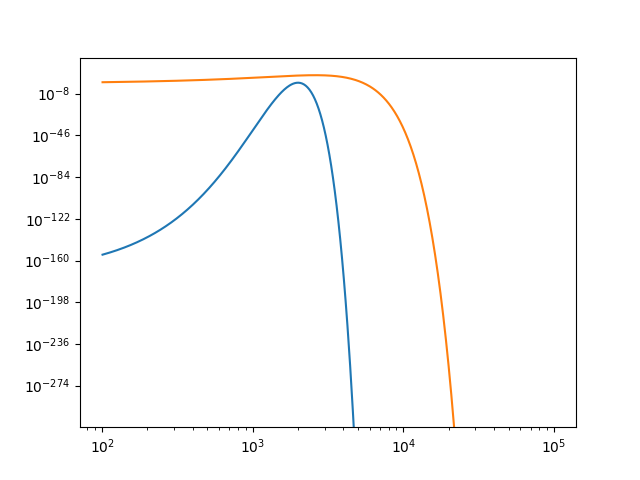

In [37]:
maxwell_diff_flux(e_bin_mean, 10, 1e3, 1e2, 2)
plt.figure()
plt.plot(e_bin_mean, maxwell_diff_flux(e_bin_mean, 100, 2e3, 1e2, 2))
plt.plot(e_bin_mean, pol_diff_flux(e_bin_mean, [0, 0.01, -0.000002]))
plt.yscale('log')
plt.xscale('log')

In [38]:
#clip the models in altitude
cutoff_ind = np.where(z_fm == 200000)[0][0]
z_c = z_fm[:cutoff_ind]
fm_c = fm_ps[:cutoff_ind]

err_c = err_fm[:cutoff_ind]
#ne_mod_c = ne_mod[:cutoff_ind] #difened later, and wrong actually => TODO
#ne_mod_c = np.zeros(len(z_c))

cutoff_ind_r = np.where(z_r >= 200000)[0][0]
z_r_c = z_r[:cutoff_ind_r]
zr_lim_c = zr_lim[:cutoff_ind_r+1]
ne_meas_c = ne_meas[:, :cutoff_ind_r]
dne_c = dne[:, :cutoff_ind_r]


In [39]:
def forward_model_n0(z_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z_msis, mass_density, inc_B):
    """ 
    builds a forward model for electron production due to a differential flux into the ionosphere accoring
    to Semeter and Kamalabadi (2005).
    
    Parameters:
    z_fm: heights where the forward model is evaluated
        ndarray
    df_par: parameters of the differential flux model
        ndarray
    z_sd_min: lower altitude to calculate scattering depth IN METERS
        scalar
    z_sd_max: upper altitude to calculate scattering depth IN METERS
        scalar
    res_sd: resolution in height of density in height for calculation of scattering depth IN METERS
        scalar
    e_bin_lims: limits of energy bins
        ndarray
    z: parametrization of mass_density (height information)
        ndarray
    mass_density: mass_density resolved in height, parametrized by z
        ndarray
    inc_B: inclination of the magnetic field.
        scalar
        
    Returns:
    fm, the forward model and the corresponding heights z_fm 
    """
    md_fm = interp_md(z_msis, mass_density, z_fm)
    
    z_sd = np.arange(z_sd_min, z_sd_max, res_sd)
    md_sd = interp_md(z_msis, mass_density, z_sd)
    
    e_bin_mean = (e_bin_lims[1:] + e_bin_lims[:-1]) / 2
    e_bin_width = e_bin_lims[1:] - e_bin_lims[:-1]
    
    fm = np.zeros([len(z_fm), len(e_bin_mean)])
    for i in range(len(z_fm)):
        if i/len(z_fm)%0.1 == 0: print(i/len(z_fm)) 
        #use interpolated values for mass density (mdp) and height (zp)
        scat_d = scattering_depth(md_sd, z_sd, z_fm[i], inc_B)
        for j in range(len(e_bin_mean)):
            ran = e_range(e_bin_mean[j])
            energy_diss = E_diss_func(scat_d, ran)
            fm[i, j] = energy_diss * md_fm[i] * e_bin_mean[j] * e_bin_width[j] / (35.5 * ran)
    return fm, z_fm


fm_0, z_fm_0 = forward_model_n0(z_r_c, z_sd_min, z_sd_max, res_sd, e_bin_lims, z_msis, mass_density, inc_B)

if printing:
    plt.figure()
    for i in range(5):
        plt.plot(fm_0[:, i*100]*diff_flux[i*100], z_r_c/1e3, label = '%.2f keV' % (e_bin_mean[i*100]/1000))#, marker = '.')
    plt.xscale('log')
    plt.ylabel('Altidude [km]')
    plt.xlabel('Ion production rate [m^-3 s^-1]')
    plt.legend()
    plt.grid()
    #plt.ylim(50, 300)
    #plt.xlim(1e5, 1e11)



0.0
92374.90560657844 92380.0
94614.86953602625 94620.0
97633.2313703989 97640.0
100279.04824343909 100280.0
103279.07699169908 103280.0
106475.76389451239 106480.0
110024.89185122511 110030.0
114731.5372781202 114740.0
120230.63233774518 120240.0
126004.05717304678 126010.0
133716.51132422598 133720.0
142801.0239749941 142810.0
152371.7381293203 152380.0
163044.02399916216 163050.0
174372.07796206843 174380.0
186685.23750387944 186690.0


[ 1.82498519e+01 -4.24869475e-04 -4.35589291e-13]
[]
[]
[]


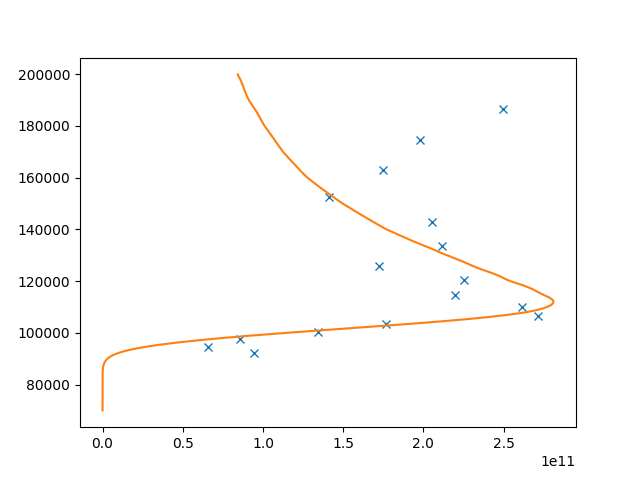

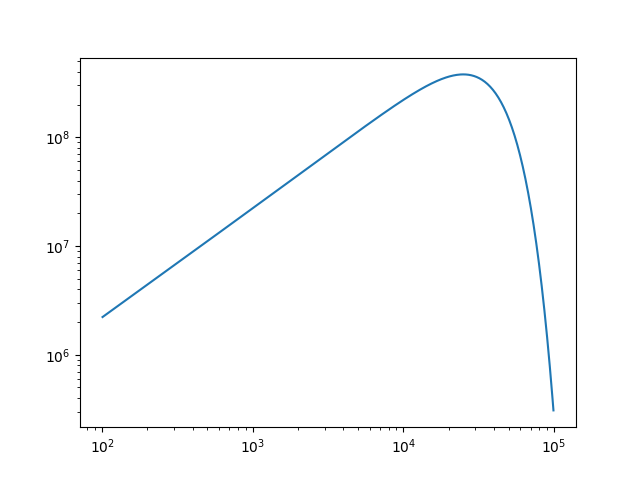

In [94]:
"""
first estimate of ne_mod
"""
printing = 1

#[u, s, vh] = np.linalg.svd(fm_0)
#v = vh.T
#
##moore penrose pseudo-inverse:
#s_inv = np.zeros([vh.shape[0], u.shape[0]])
#s_inv[:len(s), :len(s)] = np.diag(s/(s**2 + 10**2))
#fm_pinv = np.dot(v, np.dot(s_inv, u.T))

err_r_c = CubicSpline(z_iri, eff_recr)(z_r_c)

def sos_ne0(par, e_bin_mean, ne_obs, var, fm_0, err_0):
    diff_flux = pol_diff_flux(e_bin_mean, par)
    ne_mod = np.sqrt(np.dot(fm_0, diff_flux)/err_0)
    s = np.sum((ne_obs - ne_mod)**2/var**2)
    return s

param = [10, 0.00001, -0.000000001]

result_t0 = minimize(sos_ne0, 
                param,
                method = 'Nelder-Mead',
                bounds = [(None, None),(None, None),(-np.inf, 0)], 
                args=(e_bin_mean, ne_meas_c[0], dne_c[0], fm_0, err_r_c)
                )

print(result_t0.x)

ne_mod0 = np.sqrt(np.dot(fm_c, pol_diff_flux(e_bin_mean, result_t0.x))/err_c)
  
print([(ind, i) for ind, i in enumerate(np.dot(fm_c, pol_diff_flux(e_bin_mean, result_t0.x))/err_c) if i<0])
print(fm_ps[fm_ps<0])
print(fm[fm<0])


plt.figure()
plt.plot(ne_meas_c[0], z_r_c, 'x')
plt.plot(ne_mod0, z_c)

plt.figure()
plt.plot(e_bin_mean, pol_diff_flux(e_bin_mean, param))
plt.xscale('log')
plt.yscale('log')

In [95]:
def sos2(param, ne_meas, var,  dt, t0, t1, fm_ps, ne_0, eff_recr, z_r, zr_lim, z_ne_mod):
    """
    Calculates the Sum of Squares
    
    Parameters:
    diff_flux: variable to be optimized. Differential flux precipitating on the ionosphere.
        dn/dt = fm_p . diff_flux - eff_recr * ne_0
        ndarray 
    ne_meas: measured electron density
        ndarray
    var: variances of ne_meas
        ndarray
    dt: timestep to progress the integration
        scalar
    t0: integration start time
        scalar
    t1: integration end time
        scalar
    fm_ps: the pulse-smeared forward model for priduction.
        ndarray
    ne_0: initial electron density estimate. is replaced after dt with the ne_t1p = ne + dn/dt * dt
        ndarray
    eff_recr: effective recombination rate
        ndarray
    
    Returns:
    sumofs: Sum of Square: Differences between m_meas and height-integrated ne_int, weighted by the variance var.
    """
    diff_flux = pol_diff_flux(e_bin_mean, param)
    ne_tp1 = ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr)
            #ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr)
    if (ne_tp1<0).any(): raise RuntimeError('Negative Electron Density')
    ne_int = np.zeros(len(z_r))
    for i in range(len(z_r)):
        ne_int[i] = ne_height_int(z_ne_mod, ne_tp1, zr_lim[i], zr_lim[i+1])

    #print(ne_meas)
    #print(ne_int)
    #print(var)
    sumofs = np.sum((ne_meas - ne_int)**2 / var**2)

    return sumofs

def ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr):
    """
    Integration of the electron density in time:
    ne(t+dt) = ne(t) + dne/dt * dt = ne_0 + (A.phi - alpha ne**2) * dt 
    
    Paramters:
    diff_flux: phi: differential number flux
        ndarray
    dt: length of the time step to integrate
        scalar
    t0: start time fo integration
        scalar
    t1: end of integration
        scalar
    fm_ps: A: forward model to desribe production profile q = A.phi
        ndarray (len(z_fm) x len(diff_flux))
    ne_0: ne(t = t0): electron density as height profile at the start
        nd_array (len(z_fm))
    eff_recr: alpha: effective recombination rate as a height profile
        ndarray (len(z_fm))
    
    Returns:
    The integrated electron density after dt: ne(t+dt)
    """
    t = t0
    while t < t1:
        dnedt = np.dot(fm_ps, diff_flux) - eff_recr * ne_0**2
        ne = ne_0 + dnedt * dt
        
        t = t + dt
        ne_0 = ne
    return ne

In [ ]:
#time steps for integration in seconds:
delta_t = 0.01

fit = []
fit.append(result_t0)
ne_fit = np.empty([len(r_time), len(z_c)])
ne_mod_c = ne_mod0
ne_fit[0] = ne_mod_c

if printing:
    fig = plt.figure()
    
    
param = result_t0.x
#param = [0, 0.01, -0.000002]
#             x: array([-2.31760126e-02,  2.63704831e-03, -1.40279493e-07]) old values, update

for ind in range(len(r_time)-1):
    print(ind, 'of', len(r_time)-1, 'time = ', r_time[ind+1])
    
    result = minimize(sos2, 
                      param,
                      method = 'Nelder-Mead',
                      bounds = [(None, None),(None, None),(-np.inf, 0)], 
                      args=(ne_meas_c[ind+1], dne_c[ind+1], delta_t, r_time[ind], r_time[ind+1], fm_c, ne_mod_c, err_c, z_r_c, zr_lim_c, z_c)
                           #ne_meas,           var,         dt,      t0,          t1,            fm_ps, ne_0,   eff_recr, z_r, zr_lim,   z_ne_mod):
                     )
    fit.append(result)
    print(fit[ind])

#    result = minimize(sos, 
#                      param,
#                      method = 'Nelder-Mead',
#                      bounds = [(0, np.inf),(0, np.inf),(0, np.inf),(0.5, 5)], 
#                      args=(ne_meas[i+1], dne[i+1], delta_t, r_time[i], r_time[i+1], fm_ps, ne_mod, err)
#                     )
    
    #prepare for next iteration:
    diff_flux = pol_diff_flux(e_bin_mean, result.x)
    ne_tp1 = ne_time_int(diff_flux, delta_t, r_time[ind], r_time[ind+1], fm_c, ne_mod_c, err_c)
    ne_mod_c = ne_tp1
    param = result.x
    
    ne_fit[ind+1, :] = ne_tp1
    

if printing == 1:
    plt.legend()

0 of 43 time =  70235.99760900065
 final_simplex: (array([[ 1.82498519e+01, -4.24869475e-04, -4.35589291e-13],
       [ 1.82499218e+01, -4.24880907e-04, -4.24801202e-13],
       [ 1.82498455e+01, -4.24875089e-04, -4.17392024e-13],
       [ 1.82498136e+01, -4.24866640e-04, -4.32569373e-13]]), array([189.311444  , 189.3114451 , 189.31144569, 189.31144789]))
           fun: 189.3114439972496
       message: 'Optimization terminated successfully.'
          nfev: 299
           nit: 170
        status: 0
       success: True
             x: array([ 1.82498519e+01, -4.24869475e-04, -4.35589291e-13])
1 of 43 time =  70239.99759000167
 final_simplex: (array([[ 1.90610740e+01, -3.75906542e-04, -4.55009556e-13],
       [ 1.90610079e+01, -3.75903601e-04, -4.55015516e-13],
       [ 1.90611149e+01, -3.75912490e-04, -4.55004674e-13],
       [ 1.90611491e+01, -3.75915667e-04, -4.54989879e-13]]), array([137.14536921, 137.14536959, 137.14536975, 137.14537111]))
           fun: 137.14536921332603
     

(44, 1300)


/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_93424/3671539396.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(r_time, z_c/1e3, np.log10(ne_fit.T), vmin = 11, vmax = 12)


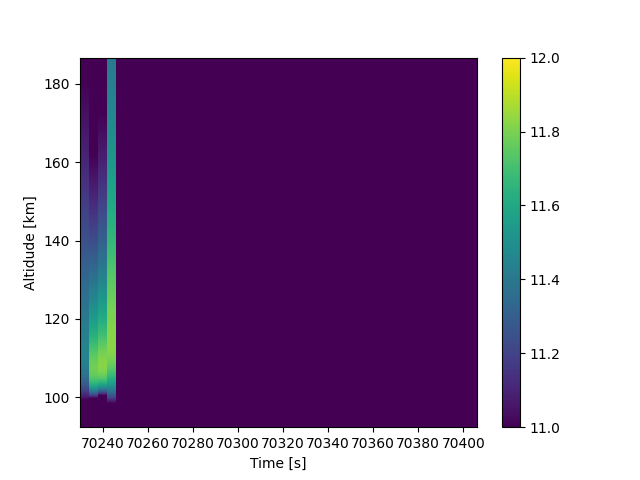

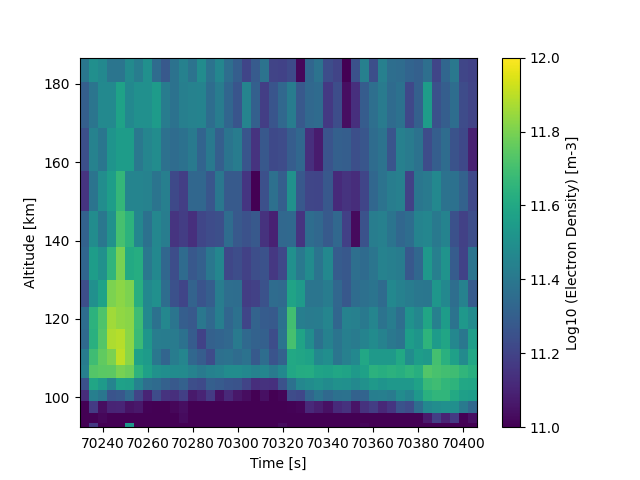

In [43]:
print(ne_fit.shape)
plt.figure()
plt.pcolormesh(r_time, z_c/1e3, np.log10(ne_fit.T), vmin = 11, vmax = 12)
plt.colorbar()
plt.ylabel('Altidude [km]')
plt.xlabel('Time [s]')
plt.ylim([z_r_c[0]/1e3, z_r_c[-1]/1e3])
#plt.close()

if printing:
    plt.figure()
    plt.pcolormesh(r_time, height[0]/1e3, np.log10(ne_meas.T), vmin = 11, vmax = 12)
    plt.xlabel('Time [s]')
    plt.ylabel('Altitude [km]')
    plt.ylim([z_r_c[0]/1e3, z_r_c[-1]/1e3])
    cb = plt.colorbar()
    cb.set_label('Log10 (Electron Density) [m-3]')

In [44]:
for i in fit:
    print(i.success)

True
True
True
True


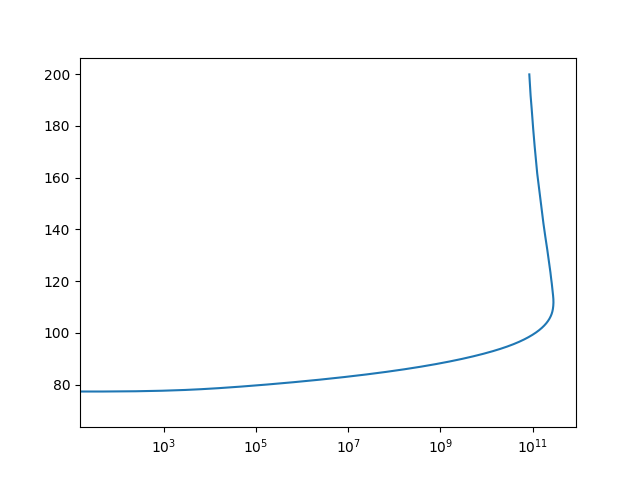

In [45]:
plt.figure()
plt.plot(ne_fit[0], z_c/1e3)
#plt.plot(ne_fit[1], z_c/1e3)

plt.xscale('log')

In [46]:
result

 final_simplex: (array([[ 2.02629697e+01, -4.09325221e-04, -6.36674070e-09],
       [ 2.02629863e+01, -4.09330701e-04, -6.36654969e-09],
       [ 2.02628744e+01, -4.09303078e-04, -6.36798693e-09],
       [ 2.02629373e+01, -4.09309579e-04, -6.36781465e-09]]), array([157.51415864, 157.51415868, 157.51415892, 157.51415894]))
           fun: 157.51415864015354
       message: 'Optimization terminated successfully.'
          nfev: 345
           nit: 196
        status: 0
       success: True
             x: array([ 2.02629697e+01, -4.09325221e-04, -6.36674070e-09])

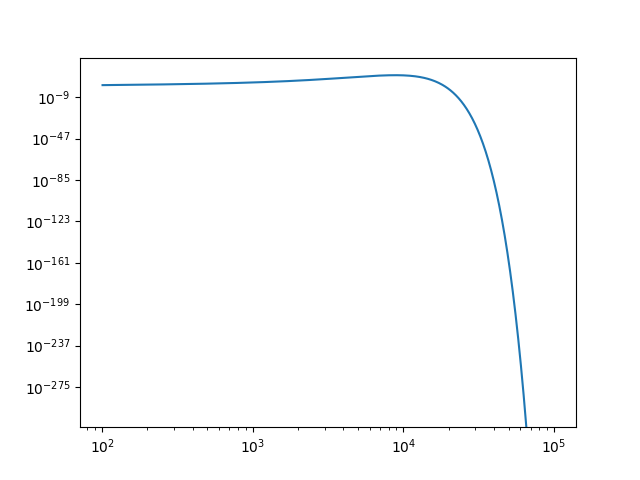

In [47]:
plt.figure()
plt.plot(e_bin_mean, pol_diff_flux(e_bin_mean, fit[2].x))
plt.yscale('log')
plt.xscale('log')

In [48]:
fit[1]

 final_simplex: (array([[ 4.77512395e-03,  3.56741009e-03, -1.92904455e-07],
       [ 4.77498396e-03,  3.56793257e-03, -1.92954420e-07],
       [ 4.77498990e-03,  3.56795799e-03, -1.92954191e-07],
       [ 4.77500877e-03,  3.56792705e-03, -1.92950731e-07]]), array([807.10521823, 807.10523503, 807.1052699 , 807.10529729]))
           fun: 807.1052182302216
       message: 'Optimization terminated successfully.'
          nfev: 240
           nit: 133
        status: 0
       success: True
             x: array([ 4.77512395e-03,  3.56741009e-03, -1.92904455e-07])

In [49]:
print([f.x for f in fit])

[array([ 1.82498519e+01, -4.24869475e-04, -4.35589291e-13]), array([ 4.77512395e-03,  3.56741009e-03, -1.92904455e-07]), array([ 4.57579893e-03,  3.94429866e-03, -2.29572620e-07]), array([ 2.02629697e+01, -4.09325221e-04, -6.36674070e-09])]


In [50]:
for f in fit:
    par = f.x
    diff_flux = pol_diff_flux(e_bin_mean, par)
result.x

array([ 2.02629697e+01, -4.09325221e-04, -6.36674070e-09])

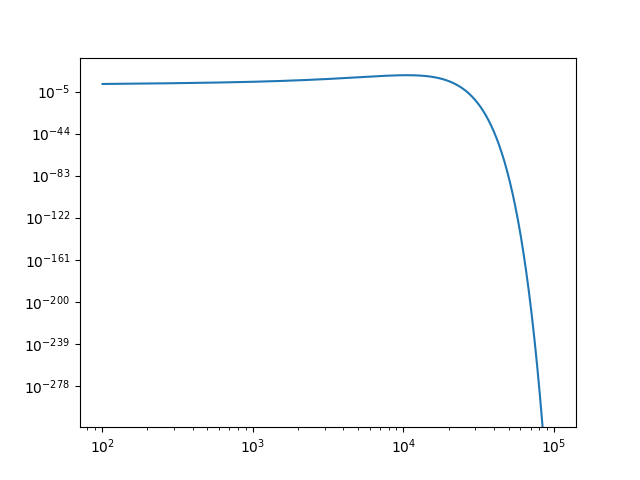

In [51]:
plt.figure()
plt.plot(e_bin_mean, pol_diff_flux(e_bin_mean, [ 9.30941045e-03,  2.82050985e-03, -1.38052857e-07]))
plt.xscale('log')
plt.yscale('log')

In [ ]:
for i in fit:
    plt.plot(e_bin_mean, pol3_diff_flux(fit.x))

[ 1.86421376e+01 -5.16833339e-04  4.15756160e-09 -8.02510832e-14]
[]
[]
[]


/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_93424/3204878351.py:26: RuntimeWarning: overflow encountered in exp
  diff_flux = e * np.exp(p[0] + p[1]*e + p[2]*e**2)
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_93424/3204878351.py:26: RuntimeWarning: overflow encountered in multiply
  diff_flux = e * np.exp(p[0] + p[1]*e + p[2]*e**2)


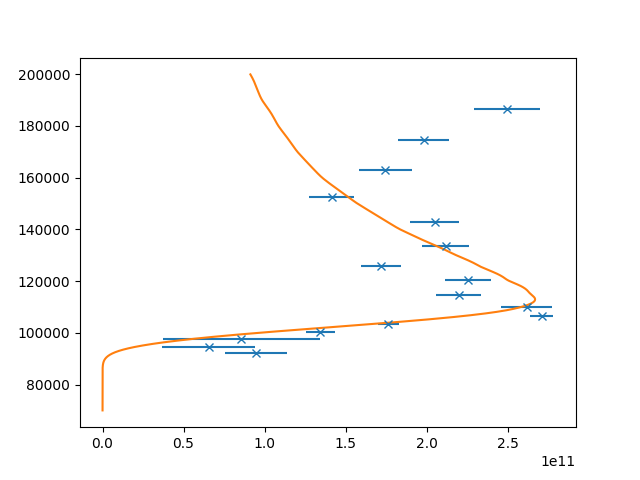

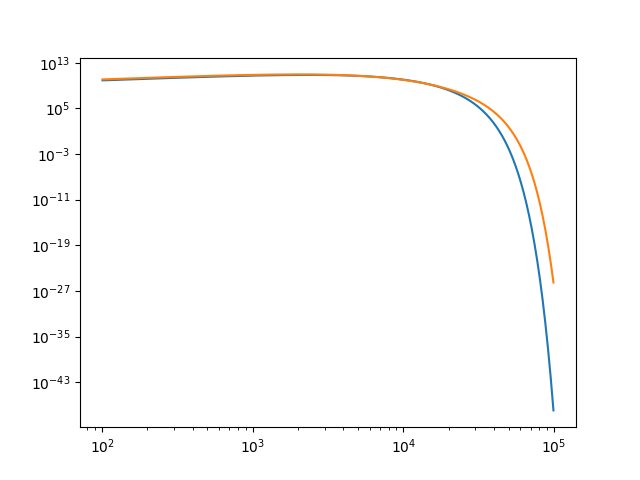

In [86]:
"""
using pol3

first estimate of ne_mod
"""
printing = 1

#[u, s, vh] = np.linalg.svd(fm_0)
#v = vh.T
#
##moore penrose pseudo-inverse:
#s_inv = np.zeros([vh.shape[0], u.shape[0]])
#s_inv[:len(s), :len(s)] = np.diag(s/(s**2 + 10**2))
#fm_pinv = np.dot(v, np.dot(s_inv, u.T))

err_r_c = CubicSpline(z_iri, eff_recr)(z_r_c)

def sos_ne0_p4(par, e_bin_mean, ne_obs, var, fm_0, err_0):
    diff_flux = pol_diff_flux(e_bin_mean, par)
    ne_mod = np.sqrt(np.dot(fm_0, diff_flux)/err_0)
    s = np.sum((ne_obs - ne_mod)**2/var**2)
    return s

param = [10, 0.00001, -0.000000001, -0.000000000000001]
param = [ 1.82507657e+01, -4.24907738e-04,  0,   -0.0000000000001]


result_t0 = minimize(sos_ne0_p4, 
                param,
                method = 'Nelder-Mead',
                bounds = [(None, None),(None, None),(-np.inf, np.inf),(-np.inf, 0)], 
                args=(e_bin_mean, ne_meas_c[0], dne_c[0], fm_0, err_r_c)
                )

print(result_t0.x)

ne_mod0 = np.sqrt(np.dot(fm_c, pol3_diff_flux(e_bin_mean, result_t0.x))/err_c)
  
print([(ind, i) for ind, i in enumerate(np.dot(fm_c, pol3_diff_flux(e_bin_mean, result_t0.x))/err_c) if i<0])
print(fm_ps[fm_ps<0])
print(fm[fm<0])


plt.figure()
plt.errorbar(ne_meas_c[0], z_r_c, xerr = dne_c[0], marker = 'x', linestyle = ' ')
plt.plot(ne_mod0, z_c)

plt.figure()
plt.plot(e_bin_mean, pol3_diff_flux(e_bin_mean, param))
plt.plot(e_bin_mean, pol3_diff_flux(e_bin_mean, result_t0.x))

plt.xscale('log')
plt.yscale('log')

In [91]:
def sos2_p3(param, ne_meas, var,  dt, t0, t1, fm_ps, ne_0, eff_recr, z_r, zr_lim, z_ne_mod):
    """
    Calculates the Sum of Squares
    
    Parameters:
    diff_flux: variable to be optimized. Differential flux precipitating on the ionosphere.
        dn/dt = fm_p . diff_flux - eff_recr * ne_0
        ndarray 
    ne_meas: measured electron density
        ndarray
    var: variances of ne_meas
        ndarray
    dt: timestep to progress the integration
        scalar
    t0: integration start time
        scalar
    t1: integration end time
        scalar
    fm_ps: the pulse-smeared forward model for priduction.
        ndarray
    ne_0: initial electron density estimate. is replaced after dt with the ne_t1p = ne + dn/dt * dt
        ndarray
    eff_recr: effective recombination rate
        ndarray
    
    Returns:
    sumofs: Sum of Square: Differences between m_meas and height-integrated ne_int, weighted by the variance var.
    """
    diff_flux = pol3_diff_flux(e_bin_mean, param)
    ne_tp1 = ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr)
            #ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr)
    if (ne_tp1<0).any(): 
        return 2**30
        #raise RuntimeError('Negative Electron Density')
    ne_int = np.zeros(len(z_r))
    for i in range(len(z_r)):
        ne_int[i] = ne_height_int(z_ne_mod, ne_tp1, zr_lim[i], zr_lim[i+1])

    #print(ne_meas)
    #print(ne_int)
    #print(var)
    sumofs = np.sum((ne_meas - ne_int)**2 / var**2)

    return sumofs

0 of 43 time =  70235.99760900065
 final_simplex: (array([[ 1.86421376e+01, -5.16833339e-04,  4.15756160e-09,
        -8.02510832e-14],
       [ 1.86420668e+01, -5.16819970e-04,  4.15740474e-09,
        -8.02587152e-14],
       [ 1.86420541e+01, -5.16822550e-04,  4.15744985e-09,
        -8.02584618e-14],
       [ 1.86420894e+01, -5.16824895e-04,  4.15749397e-09,
        -8.02563269e-14],
       [ 1.86421622e+01, -5.16836381e-04,  4.15763196e-09,
        -8.02494301e-14]]), array([157.82009101, 157.82009108, 157.82009129, 157.82009154,
       157.82009253]))
           fun: 157.82009100681046
       message: 'Optimization terminated successfully.'
          nfev: 400
           nit: 208
        status: 0
       success: True
             x: array([ 1.86421376e+01, -5.16833339e-04,  4.15756160e-09, -8.02510832e-14])
1 of 43 time =  70239.99759000167
 final_simplex: (array([[ 2.03579965e+01, -8.14287911e-04,  3.81767577e-08,
        -9.31502540e-13],
       [ 2.03579083e+01, -8.14257737e-

/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_93424/2669881929.py:70: RuntimeWarning: overflow encountered in square
  dnedt = np.dot(fm_ps, diff_flux) - eff_recr * ne_0**2


 final_simplex: (array([[ 2.03934302e+01, -4.77201606e-04,  8.12423218e-11,
         0.00000000e+00],
       [ 2.03933635e+01, -4.77190403e-04,  8.08495861e-11,
         0.00000000e+00],
       [ 2.03933336e+01, -4.77181117e-04,  8.04451964e-11,
         0.00000000e+00],
       [ 2.03934368e+01, -4.77206783e-04,  8.16178476e-11,
         0.00000000e+00],
       [ 2.03933735e+01, -4.77188909e-04,  8.05475690e-11,
         0.00000000e+00]]), array([77.85138145, 77.85138151, 77.85138152, 77.85138176, 77.85138197]))
           fun: 77.8513814454113
       message: 'Optimization terminated successfully.'
          nfev: 190
           nit: 111
        status: 0
       success: True
             x: array([ 2.03934302e+01, -4.77201606e-04,  8.12423218e-11,  0.00000000e+00])
6 of 43 time =  70259.997676
 final_simplex: (array([[ 2.02297394e+01, -5.81687271e-04,  4.59897278e-09,
         0.00000000e+00],
       [ 2.02296978e+01, -5.81680713e-04,  4.59892043e-09,
         0.00000000e+00],
      

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 final_simplex: (array([[ 1.69172677e+01, -1.93017966e-04, -1.97201710e-09,
         0.00000000e+00],
       [ 1.69172254e+01, -1.93012264e-04, -1.97222442e-09,
         0.00000000e+00],
       [ 1.69173094e+01, -1.93025040e-04, -1.97177805e-09,
         0.00000000e+00],
       [ 1.69172225e+01, -1.93014659e-04, -1.97207322e-09,
         0.00000000e+00],
       [ 1.69172879e+01, -1.93023191e-04, -1.97179245e-09,
         0.00000000e+00]]), array([230.24350759, 230.2435076 , 230.24350761, 230.24350762,
       230.24350776]))
           fun: 230.24350758935728
       message: 'Optimization terminated successfully.'
          nfev: 198
           nit: 112
        status: 0
       success: True
             x: array([ 1.69172677e+01, -1.93017966e-04, -1.97201710e-09,  0.00000000e+00])


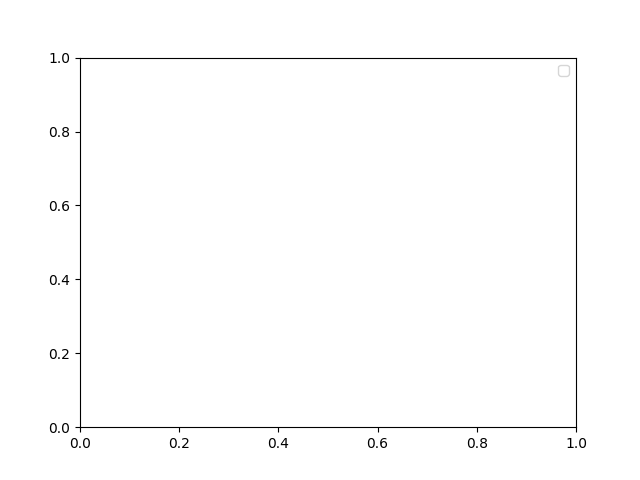

In [92]:
#time steps for integration in seconds:
delta_t = 0.01

fit3 = []
fit3.append(result_t0)
ne_fit3 = np.empty([len(r_time), len(z_c)])
ne_mod_c = ne_mod0
ne_fit3[0] = ne_mod_c

if printing:
    fig = plt.figure()

param = result_t0.x

for ind in range(len(r_time)-1):
    print(ind, 'of', len(r_time)-1, 'time = ', r_time[ind+1])
    
    result = minimize(sos2_p3, 
                      param,
                      method = 'Nelder-Mead',
                      bounds = [(None, None),(None, None),(None, None),(-np.inf, 0)], 
                      args=(ne_meas_c[ind+1], dne_c[ind+1], delta_t, r_time[ind], r_time[ind+1], fm_c, ne_mod_c, err_c, z_r_c, zr_lim_c, z_c)
                           #ne_meas,           var,         dt,      t0,          t1,            fm_ps, ne_0,   eff_recr, z_r, zr_lim,   z_ne_mod):
                     )
    fit3.append(result)
    print(fit3[ind])

#    result = minimize(sos, 
#                      param,
#                      method = 'Nelder-Mead',
#                      bounds = [(0, np.inf),(0, np.inf),(0, np.inf),(0.5, 5)], 
#                      args=(ne_meas[i+1], dne[i+1], delta_t, r_time[i], r_time[i+1], fm_ps, ne_mod, err)
#                     )
    
    #prepare for next iteration:
    diff_flux = pol3_diff_flux(e_bin_mean, result.x)
    ne_tp1 = ne_time_int(diff_flux, delta_t, r_time[ind], r_time[ind+1], fm_c, ne_mod_c, err_c)
    ne_mod_c = ne_tp1
    param = result.x
    
    ne_fit3[ind+1, :] = ne_tp1
    

if printing == 1:
    plt.legend()

(44, 1300)


/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_93424/3671539396.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(r_time, z_c/1e3, np.log10(ne_fit.T), vmin = 11, vmax = 12)


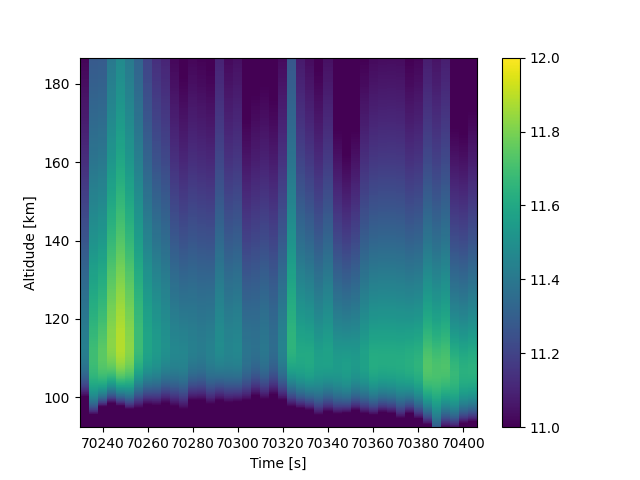

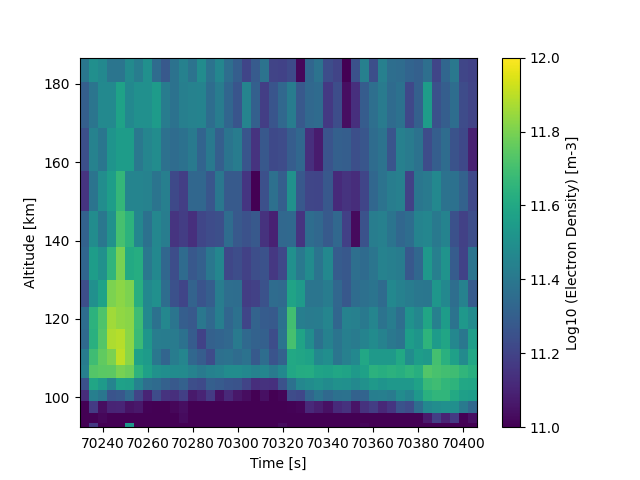

In [93]:
print(ne_fit.shape)
plt.figure()
plt.pcolormesh(r_time, z_c/1e3, np.log10(ne_fit.T), vmin = 11, vmax = 12)
plt.colorbar()
plt.ylabel('Altidude [km]')
plt.xlabel('Time [s]')
plt.ylim([z_r_c[0]/1e3, z_r_c[-1]/1e3])
#plt.close()

if printing:
    plt.figure()
    plt.pcolormesh(r_time, height[0]/1e3, np.log10(ne_meas.T), vmin = 11, vmax = 12)
    plt.xlabel('Time [s]')
    plt.ylabel('Altitude [km]')
    plt.ylim([z_r_c[0]/1e3, z_r_c[-1]/1e3])
    cb = plt.colorbar()
    cb.set_label('Log10 (Electron Density) [m-3]')

In [ ]:
for i in fit:
    plt.plot(e_bin_mean, pol3_diff_flux(fit.x))